In [1]:
from finger import Finger

from physics.gen.mass_matrix import mass_matrix
from physics.gen.bias_forces import bias_forces

from physics.simulate import step
from physics.visualize import animate

import jax
import jax.numpy as jnp
import jax.profiler
import flax
from flax import linen as nn
from flax import struct
import optax

import jax.experimental.host_callback

from training.infos import Infos

import shutil

from einops import einops, einsum
import matplotlib.pyplot as plt

from embeds import EmbeddingLayer
from training.rollout import collect_rollout

from training.eval_actor import evaluate_actor
from training.vibe_state import (
    VibeState,
    TrainConfig,
)
from training.inference import (
    infer_states,
    encode_state,
    decode_state,
    decode_action,
)
from training.nets import (
    StateEncoder,
    ActionEncoder,
    StateSizer,
    TransitionModel,
    StateDecoder,
    ActionDecoder,
    encoded_state_dim,
    encoded_action_dim,
)

import orbax.checkpoint as ocp

# from unitree_go1 import UnitreeGo1

from training.train import train_step, dump_to_wandb
from policy import (
    random_policy,
    random_repeat_policy,
    make_target_conf_policy,
    make_piecewise_actor,
    random_action,
    make_finder_policy,
)  # , max_dist_policy

import matplotlib.cm as cm

import os

%matplotlib inline

In [2]:
seed = 1

# Generate random key
key = jax.random.PRNGKey(seed)

checkpointer = ocp.PyTreeCheckpointer()

learning_rate = float(2.5e-4)
every_k = 4

env_cls = Finger

env_config = env_cls.get_config()

schedule = optax.cosine_onecycle_schedule(
    8192,
    peak_value=learning_rate,
    pct_start=0.125,
    div_factor=1.0,
    final_div_factor=10.0,
)

vibe_config = TrainConfig.init(
    learning_rate=learning_rate,
    optimizer=optax.MultiSteps(
        optax.chain(
            optax.zero_nans(),
            optax.clip_by_global_norm(200.0),
            optax.lion(learning_rate=1),
        ),
        every_k_schedule=every_k,
    ),
    state_encoder=StateEncoder(),
    action_encoder=ActionEncoder(),
    state_sizer=StateSizer(),
    transition_model=TransitionModel(1e4, 6, 64, 4),
    state_decoder=StateDecoder(env_config.state_dim),
    action_decoder=ActionDecoder(env_config.act_dim),
    env_config=env_config,
    seed=seed,
    rollouts=256,
    epochs=256,
    batch_size=128,
    every_k=every_k,
    traj_per_rollout=4096,
    rollout_length=509,
    reconstruction_weight=1.0,
    forward_weight=1.0,
    smoothness_weight=1.0,
    condensation_weight=1.0,
    dispersion_weight=1.0,
    inverse_reconstruction_gate_sharpness=1,
    inverse_forward_gate_sharpness=1,
    inverse_reconstruction_gate_center=-9,
    inverse_forward_gate_center=-9,
    forward_gate_sharpness=1,
    smoothness_gate_sharpness=1,
    dispersion_gate_sharpness=1,
    condensation_gate_sharpness=1,
    forward_gate_center=-2,
    smoothness_gate_center=-5,
    dispersion_gate_center=-9,
    condensation_gate_center=-9,
)

rng, key = jax.random.split(key)
vibe_state = VibeState.init(rng, vibe_config)

In [3]:
rng, key = jax.random.split(key)
vibe_state = VibeState.init(rng, vibe_config)

checkpoint_dir = "checkpoints"

vibe_state = checkpointer.restore(
    os.path.join(checkpoint_dir, "checkpoint_r42_s512.0"), item=vibe_state
)

In [4]:
vibe_state

VibeState(step=array(86016, dtype=int32), state_encoder_params={'params': {'FC0': {'bias': array([ 4.3263141e-02, -4.3533316e+00, -4.3533316e+00,  1.0010104e-02,
       -4.3500929e+00, -2.6527269e-02, -4.2644625e+00, -4.3353772e+00,
       -4.3492942e+00, -4.3527308e+00,  1.7371980e-02,  2.5099058e-02,
       -4.3509898e+00, -1.7870286e-02, -3.8614031e-03, -4.3441234e+00,
       -4.3524828e+00, -3.9872980e+00, -4.0084543e+00, -8.5488623e-03,
        5.3676455e-03, -4.1186213e+00, -4.3533316e+00,  1.4204306e-02,
       -4.1978903e+00, -4.3109746e+00, -3.9070749e+00, -4.3524241e+00,
       -4.3526511e+00,  3.6897191e-03, -4.3495054e+00, -9.2648098e-04,
       -3.4921556e+00,  1.9289076e-02, -4.3533316e+00, -3.9717693e+00,
       -3.9061174e+00, -4.3532119e+00,  5.1528636e-02, -6.2732375e-05,
       -4.2943497e+00, -4.3305793e+00, -4.3532519e+00, -5.8836327e-03,
       -1.3426473e-02, -4.3325138e+00, -4.3533316e+00,  4.2019393e-03,
       -4.3532915e+00,  3.2232266e-02, -1.6839217e-03, -2

## Actually run the actor evals, this will take a while

In [5]:
eval_count = 4

In [6]:
rng, key = jax.random.split(key)
rngs = jax.random.split(rng, eval_count)

evaluate_actor_partial = jax.tree_util.Partial(
    evaluate_actor,
    big_step_size=0.5,
    big_steps=2048,
    small_step_size=0.001,
    small_steps=2048,
    big_post_steps=32,
    small_post_steps=32,
    target_q=2.0,
)

start_state = env_cls.init()

(result_states, result_actions), info, optimized_actions, costs = jax.vmap(
    evaluate_actor_partial, in_axes=(0, None, None, None, None)
)(
    rngs,
    start_state,
    env_cls,
    vibe_state,
    vibe_config,
)

In [7]:
# def collect_finder_rollout(key):
#     rng, key = jax.random.split(key)
#     target_state = (
#         jax.random.ball(rng, d=encoded_state_dim, p=1)
#         * vibe_config.state_radius
#         * 1.25
#     )
#     rng, key = jax.random.split(key)
#     actor, init_carry = make_finder_policy(
#         rng,
#         start_state,
#         target_state,
#         vibe_state,
#         vibe_config,
#         env_cls,
#     )

#     rng, key = jax.random.split(key)
#     rollout_result = collect_rollout(
#         start_state,
#         actor,
#         init_carry,
#         env_cls,
#         vibe_state,
#         vibe_config,
#         rng,
#     )

#     return rollout_result

# rng, key = jax.random.split(key)
# rngs = jax.random.split(rng, 256)
# finder_rollout_results = jax.vmap(collect_finder_rollout)(rngs)

In [8]:
rng, key = jax.random.split(key)

latent_start_state = encode_state(rng, start_state, vibe_state, vibe_config)

rng, key = jax.random.split(key)
rngs = jax.random.split(rng, eval_count)
predicted_latent_states = jax.vmap(
    jax.tree_util.Partial(
        infer_states,
        latent_start_state=latent_start_state,
        vibe_state=vibe_state,
        vibe_config=vibe_config,
    )
)(rngs, latent_actions=optimized_actions)

In [9]:
costs

Array([[0.7163893 , 0.7150728 , 0.71414214, ..., 0.23832507, 0.23829429,
        0.2381861 ],
       [0.7405715 , 0.739171  , 0.7375233 , ..., 0.22949906, 0.22999969,
        0.22952236],
       [0.7352501 , 0.7337431 , 0.7326537 , ..., 0.3866737 , 0.38661835,
        0.38674983],
       [0.7172992 , 0.7158472 , 0.7167223 , ..., 0.24268398, 0.24265605,
        0.24211723]], dtype=float32)

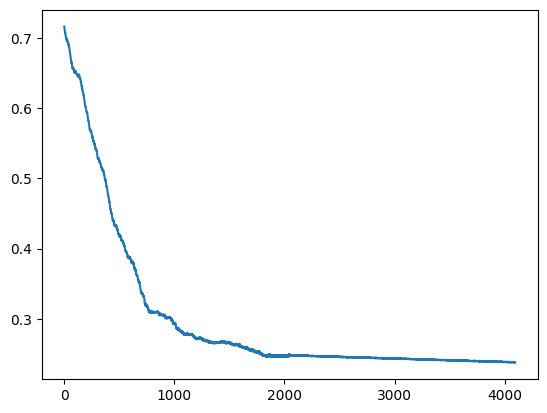

In [10]:
plt.plot(costs[0])

## Let's make a scatterplot of all of the latent states and actions the algorithm decided on

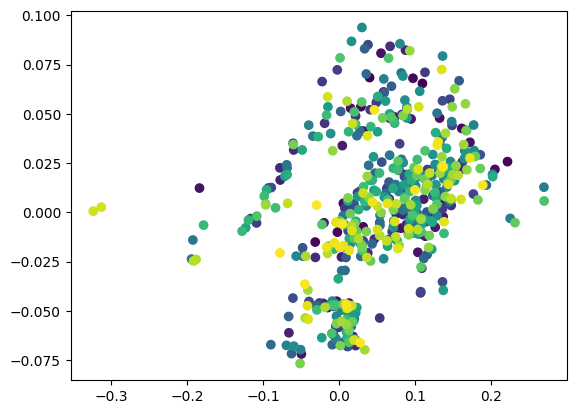

In [11]:
import numpy as np

colors = cm.viridis(np.linspace(0, 1, predicted_latent_states.shape[1]))
plt.scatter(
    predicted_latent_states[2, :, 3],
    predicted_latent_states[2, :, 4],
    c=range(predicted_latent_states.shape[1]),
    cmap="viridis",
)

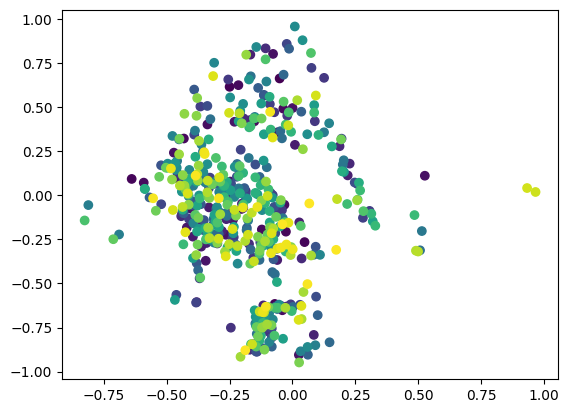

In [12]:
plt.scatter(optimized_actions[2, :, 0], optimized_actions[2, :, 1], c=range(len(optimized_actions[0])), cmap="viridis")

In [13]:
info.plain_infos['final_cost']

Array([nan, nan, nan, nan], dtype=float32)

## Let's plot the achieved final costs

/home/mishmish/Documents/go_by_vibes/vibes/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6831: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/mishmish/Documents/go_by_vibes/vibes/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6832: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

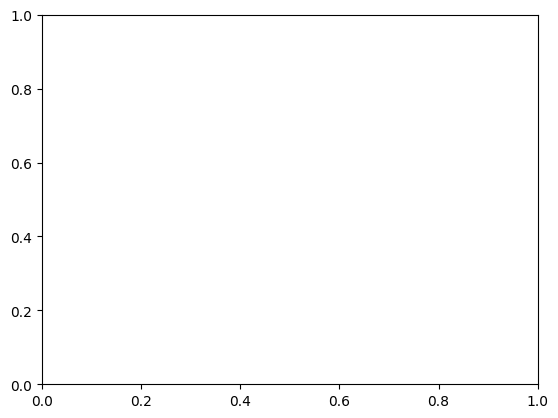

In [14]:
plt.hist(info.plain_infos['final_cost'])

## Let's visualize what the algorithm did

In [19]:
import mediapy as media

video = env_cls.host_make_video(result_states[3], env_config).transpose(0, 2, 3, 1)
media.show_video(video, fps=24)

## Let's visualize what the algorithm thought would happen

In [22]:
rng, key = jax.random.split(key)
rngs = jax.random.split(rng, predicted_latent_states.shape[1])
predicted_states = jax.vmap(
    jax.tree_util.Partial(decode_state, vibe_state=vibe_state, vibe_config=vibe_config)
)(rngs, predicted_latent_states[0])

In [23]:
video = env_cls.host_make_video(predicted_states, env_config).transpose(0, 2, 3, 1)
media.show_video(video, fps=24)

## Let's investigate what action space actions are available from the start state

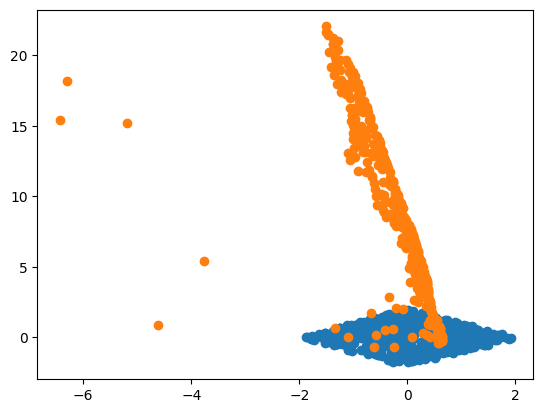

In [25]:
sample_count = 512
rng, key = jax.random.split(key)
action_samples = (
    jax.random.ball(rng, d=encoded_action_dim, p=1, shape=[sample_count])
    * vibe_config.action_radius
)

rng, key = jax.random.split(key)
rngs = jax.random.split(rng, sample_count)
action_space_actions = jax.vmap(
    jax.tree_util.Partial(
        decode_action,
        latent_state=latent_start_state,
        vibe_state=vibe_state,
        vibe_config=vibe_config,
    )
)(rngs, action_samples)

plt.scatter(x=action_samples[..., 0], y=action_samples[..., 1])
plt.scatter(x=action_space_actions[..., 0], y=action_space_actions[..., 1])

# set lims
# plt.xlim(-10, 10)
# plt.ylim(-10, 10)

In [31]:
vibe_config.env_config.action_bounds.T

Array([[-0.5, -0.5],
       [ 0.5,  1.5]], dtype=float32)